In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate Uniform Linear Array (ULA)

In [2]:
def get_ULA(el, L, N, sVar=1, phi=None, d=None, f0=2.4e9, r0=0):
    # Prepare inputs
    el = np.deg2rad(el)
    lambd = 300e6 / f0
    if d is None:
        d = lambd / 2
    M = len(el)

    # Generate URA positions
    r = np.zeros(L)
    for i in range(L):
        r[i] = i * d + r0

    # Generate signal s(t)
    t_vec = np.linspace(start=1, stop=N, num=N)
    if phi is None:
        phi = np.random.uniform(low=0, high=2*np.pi, size=(M, N))
    s = np.sqrt(sVar) * np.exp(1j * phi)

    # Generate steering matrix A(el, az)
    A = np.zeros((L, M), dtype=np.complex128)
    for m in range(M):
        A [:, m] = np.exp(2j * np.pi * np.arange(L) * d / lambd * np.cos(el[m]))

    x = A @ s

    return x, r

def get_noise(x, SNR_dB=5):
    L, N = x.shape
    SNR = 10.0**(SNR_dB / 10.0) # Desired linear SNR
    xVar = x.var() # Power of signal
    nVar = xVar / SNR # Desired power of noise
    n = np.random.normal(0, np.sqrt(nVar*2.0)/2.0, size=(L, 2*N)).view(complex)
    return n

Bartlett Beamformer

In [3]:
def bartlett_beamforming(x, r, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=-np.pi, stop=np.pi, num=resolution, endpoint=True)

    Rxx = x @ x.conj().T    # Spatial covariance matrix
    lambd = 300e6 / f0      # Wavelength
    d = r[1] - r[0]         # ULA element distance
    r0 = r[0]               # Position of first sensor

    A = np.zeros((L, resolution), dtype=np.complex128)       # Steering matrix solution
    P_bartlett = np.zeros(resolution, dtype=np.complex128)   # Bartlett solution

    for n in range(resolution):
        A[:,n] = np.exp(2j * np.pi * np.arange(L) * ((d / lambd) + r0) * np.cos(el_search[n]))
        P_bartlett[n] = (A[:,n].conj().T @ Rxx @ A[:,n]) / np.linalg.norm(A[:,n])**4

    return P_bartlett, np.rad2deg(el_search)

Capon Beamformer

In [4]:
def capon_beamforming(x, r, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=0, stop=np.pi, num=resolution, endpoint=True)

    Rxx = x @ x.conj().T    # Spatial covariance matrix
    lambd = 300e6 / f0      # Wavelength
    d = r[1] - r[0]         # ULA element distance
    r0 = r[0]               # Position of first sensor

    A = np.zeros((L, resolution), dtype=np.complex128)    # Steering matrix solution
    P_capon = np.zeros(resolution, dtype=np.complex128)   # Bartlett solution

    for n in range(resolution):
        A[:,n] = np.exp(2j * np.pi * np.arange(L) * ((d / lambd) + r0) * np.cos(el_search[n]))
        P_capon[n] = 1 / (A[:,n].conj().T @ np.linalg.inv(Rxx) @ A[:,n])

    return P_capon, np.rad2deg(el_search)

MUSIC Beamformer

In [5]:
def MUSIC_beamforming(x, r, M, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=0, stop=np.pi, num=resolution, endpoint=True)
    lambd = 300e6 / f0      # Wavelength
    d = r[1] - r[0]         # ULA element distance
    r0 = r[0]               # Position of first sensor

    # Compute correlation of the signal
    Rxx = x @ x.conj().T / N

    # Eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(Rxx)

    # Create indexation array for descenting values
    idx = np.argsort(eig_vals)
    
    # Sort eigs with indexation array
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    
    # Create Un with L-M least noise eigenvectors
    Un = eig_vecs[:, 0:(L-M)]

    A = np.zeros((L, resolution), dtype=np.complex128)       # Steering matrix solution
    P_MUSIC = np.zeros(resolution, dtype=np.complex128)   # MUSIC solution
    for n in range(resolution):
        A[:,n] = np.exp(2j * np.pi * np.arange(L) * ((d / lambd) + r0) * np.cos(el_search[n]))
        P_MUSIC[n] = 1 / (A[:,n].conj().T @ Un @ Un.conj().T @ A[:,n])

    return P_MUSIC, np.rad2deg(el_search)

Estimate M: For some reason, MMDL seems to be most precise. At least for a low number of samples and low number of impinging waves.

In [37]:
def estimate_M(x, method='MMDL'):
    L, N = x.shape
    R = x @ x.conj().T / N
    E, _ = np.linalg.eig(R)
    idx = np.argsort(E)
    E = np.flipud(E[idx])
    pn = L - 1

    if method == 'MDL':
        M_est = np.zeros(pn)
        for i in range(1, pn+1):
            term = np.prod(np.abs(E[i:pn+1]))**(1 / (L - i)) / ((1 / (L - i)) * np.sum(np.abs(E[i:pn+1])))
            M_est[i-1] = -N * (L - i) * np.log(term) + i / 2 * (2 * L - i) * np.log(N)
 
    elif method == 'AIC':
        M_est = np.zeros(pn)
        for i in range(1, pn+1):
            term = np.prod(np.abs(E[i:pn+1]))**(1 / (L - i)) / ((1 / (L - i)) * np.sum(np.abs(E[i:pn+1])))
            M_est[i-1] = -N * (L - i) * np.log(term) + i * (2 * L - i) * np.log(N)

    elif method == 'MMDL':
        p = np.arange(1, pn+1).reshape([1, pn])
        M_est = N * np.log(E[np.arange(pn)]) + 1/2 * (p**2 + p) * np.log(N)
    
    return np.argmin(M_est)

#print(estimate_M(x, 'MDL'))
#print(estimate_M(x, 'AIC'))
#print(estimate_M(x, 'MMDL'))

Execute

Text(42.722222222222214, 0.5, 'Normalized $\\hat{P}(\\theta)$')

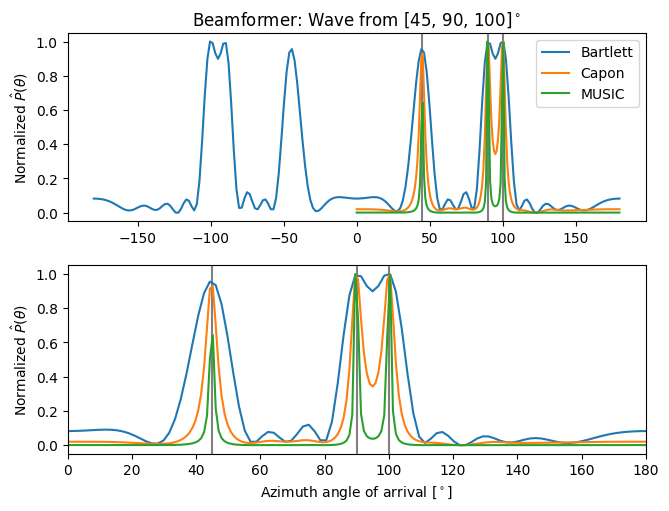

In [38]:
def normalize(arr):
    abs_arr = np.abs(arr.real)
    norm_arr = (abs_arr - np.min(abs_arr)) / (np.max(abs_arr) - np.min(abs_arr))
    return norm_arr

# Generate signals in ULA
theta_vec = [45, 90, 100]    # List of impinging waves [deg]
N = 100                 # Number of observations
L = 11                  # Number of array elements
x, r = get_ULA(theta_vec, L, N)
x += get_noise(x, 5)

# Estimate number of impinging waves
M_est = estimate_M(x, method='MMDL')

# Compute solution for beamforming
Pb, el_batlett = bartlett_beamforming(x, r)
Pc, el_capon = capon_beamforming(x, r)
Pm, el_music = MUSIC_beamforming(x, r, M_est)

# Plot solution
fig, (ax1, ax2) = plt.subplots(2, 1)
for theta in theta_vec:
    ax1.axvline(x = theta, color='gray')
    ax2.axvline(x = theta, color='gray')
fig.tight_layout()
ax1.plot(el_batlett, normalize(Pb), label='Bartlett')
ax1.plot(el_capon, normalize(Pc), label='Capon')
ax1.plot(el_music, normalize(Pm), label='MUSIC')
ax2.plot(el_batlett, normalize(Pb), label='Bartlett')
ax2.plot(el_capon, normalize(Pc), label='Capon')
ax2.plot(el_music, normalize(Pm), label='MUSIC')
ax2.set_xlim([0, np.max(el_music)])
ax1.legend()
ax1.set_title(f'Beamformer: Wave from {theta_vec}$^\\circ$')
ax1.set_ylabel('Normalized $\hat{P}(\\theta)$')
ax2.set_xlabel('Azimuth angle of arrival [$^\\circ$]')
ax2.set_ylabel('Normalized $\hat{P}(\\theta)$')